In [103]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline


import os
import glob

In [ ]:
def download_files(data, city):
    # pictures off
    chrome_options = webdriver.ChromeOptions()
    chrome_prefs = {}
    chrome_options.experimental_options["prefs"] = chrome_prefs
    chrome_prefs["profile.default_content_settings"] = {"images": 2}
    chrome_prefs["profile.managed_default_content_settings"] = {"images": 2}
    
    # download path 
    destination = os.path.join(os.getcwd(), f"{city}_files")
    os.makedirs(os.path.dirname(
        os.path.join(destination, "")), exist_ok=True)
    chrome_prefs["download.default_directory"] = destination
    
#     chrome_options.add_experimental_option('prefs', prefs)

    driver = webdriver.Chrome(os.path.join(os.getcwd(), 'chromedriver'), chrome_options=chrome_options)

    cian_Moscow = 'https://www.cian.ru'

    for i, row in data.iterrows():
        driver.get(cian_Moscow)
        #openning  a combobox
        driver.find_elements_by_class_name("_025a50318d--button--2oXjq")[1].click()

        #rooms 3 4 5 6
        rooms = driver.find_elements_by_class_name('_025a50318d--button--39rK7')
        for room in rooms[2:]:
            room.click()
        # Studio apartment & free layout
        extended_rooms = driver.find_elements_by_class_name('_025a50318d--box--VTgYk')
        for room in extended_rooms:
            room.click()

        cities = {"moscow": "Москва", "spb": "Санкт-Петербург", "ekaterinburg": "Екатерингбург"}
        search = driver.find_element_by_id("geo-suggest-input")
        if city == 'moscow':
            search.send_keys(f"{row.raion_name}, {row.okrug}, {cities[city]}")   
        else:
            search.send_keys(f"{row.raion_name}, {cities[city]}")   
        WebDriverWait(driver, 50).until(EC.element_to_be_clickable((By.CLASS_NAME, "_025a50318d--popper--c63zv")))
        search.send_keys(Keys.RETURN)
        driver.find_element_by_link_text('Найти').click()

        try:
            WebDriverWait(driver, 20).until(EC.url_contains("cat"))    
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            driver.find_element_by_class_name("_93444fe79c--main--1-d6V").click()  
        except:
            print(i, f"{row.raion_name}, {row.okrug}, Москва")



In [109]:
def get_mereged_data(city):
    if city not in ("moscow", "spb", "ekaterinburg"):
        raise ValueError('Please, choose correct city from("moscow", "spb", "ekatirinburg")')

        
    nb = os.path.join('forAnalysis', f'{city}.csv')
    regions = gpd.read_file(nb, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

    downloadspath = os.path.join(os.getcwd(), f"{city}_files", "")
    list_of_files = glob.glob(downloadspath+"*.xlsx") 
    list_of_files.sort(key=os.path.getctime)
    
    offers_data = pd.DataFrame()
    for i in range(len(list_of_files)):
        file_it = pd.read_excel(list_of_files[i])
        if not file_it.empty:
            file_it['raion_name'] = regions["raion_name"][i]
        else:
            file_it = pd.DataFrame(data={'raion_name': [regions["raion_name"][i]]})
        offers_data = pd.concat([offers_data, file_it], join='outer', ignore_index=True)
        
    return offers_data

def heat_city(city):
    if city not in ("moscow", "spb", "ekaterinburg"):
        raise ValueError('Please, choose correct city from("moscow", "spb", "ekatirinburg")')

    nb = os.path.join('forAnalysis', f'{city}.csv')
    regions = gpd.read_file(nb, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
    offers_data = get_mereged_data(city)

    offers_data["price"] = offers_data["Цена"].str.replace(' .+', '').astype(float)
    offers_data["square"] = offers_data["Площадь, м2"].str.replace('/.+', '').astype(float)

    prices_data = offers_data.groupby("raion_name").agg({"price":"sum", "square":"sum"})
    prices_data["average_price"] = prices_data.price / prices_data.square
    prices_data.sort_values("average_price", ascending=False)

    merged = regions.set_index('raion_name').join(prices_data[["average_price"]])
    merged["center"] = merged.geometry.apply(lambda x: x.centroid)

    fig, ax = plt.subplots(1, figsize=(40, 20))
    ax.axis('off')
    ax.set_title(F'Heat Map of average square meter price of appartment in {city.capitalize()} districts in rubles',
                         fontdict={'fontsize': '40', 'fontweight' : '3'})

    # price borders
    vmin, vmax, vmean = merged.average_price.min(), \
                        merged.average_price.max(), merged.average_price.mean()

    color = 'Pastel2'
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=20)

    merged.plot('average_price', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

    lower_bound, upper_bound = 5/8 * vmin + 3/8 * vmax, 5/8 * vmax + 3/8 * vmin
    # lower_bound, upper_bound = vmean, 3/4 * vmax + 1/4 * vmin
    for idx, row in merged.iterrows():
        if lower_bound < row['average_price'] and row['average_price'] < upper_bound:
            plt.annotate(text=idx, xy=np.concatenate(row["center"].coords.xy),
                         horizontalalignment='left', fontsize='large', color='black', wrap=True)

    plt.show()

In [ ]:
city = "moscow"
data = pd.read_csv(f"forAnalysis/{city}.csv")
download_files(data, f"{city}")

In [105]:
msc = get_mereged_data("moscow")

In [106]:
spb = get_mereged_data("spb")

In [107]:
ekat = get_mereged_data("ekaterinburg")

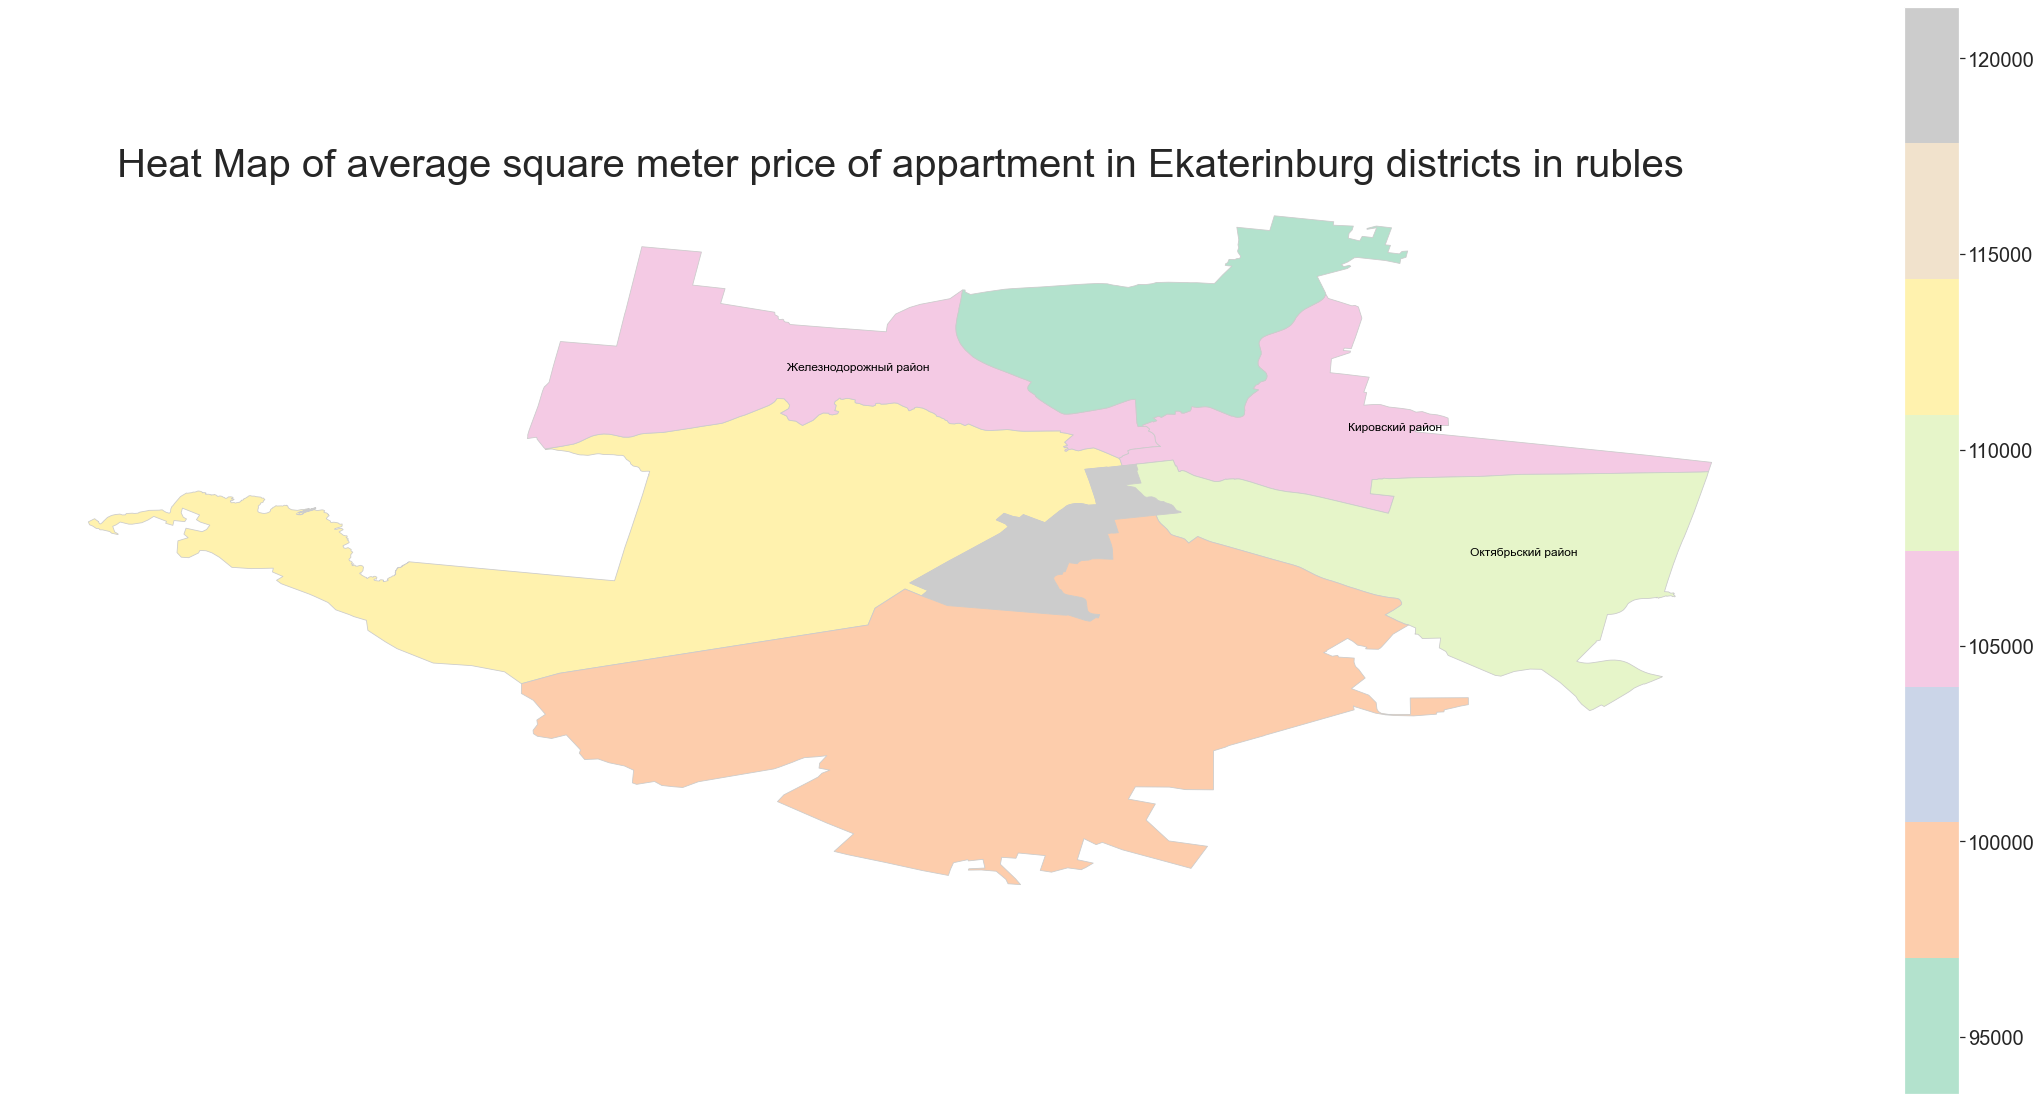

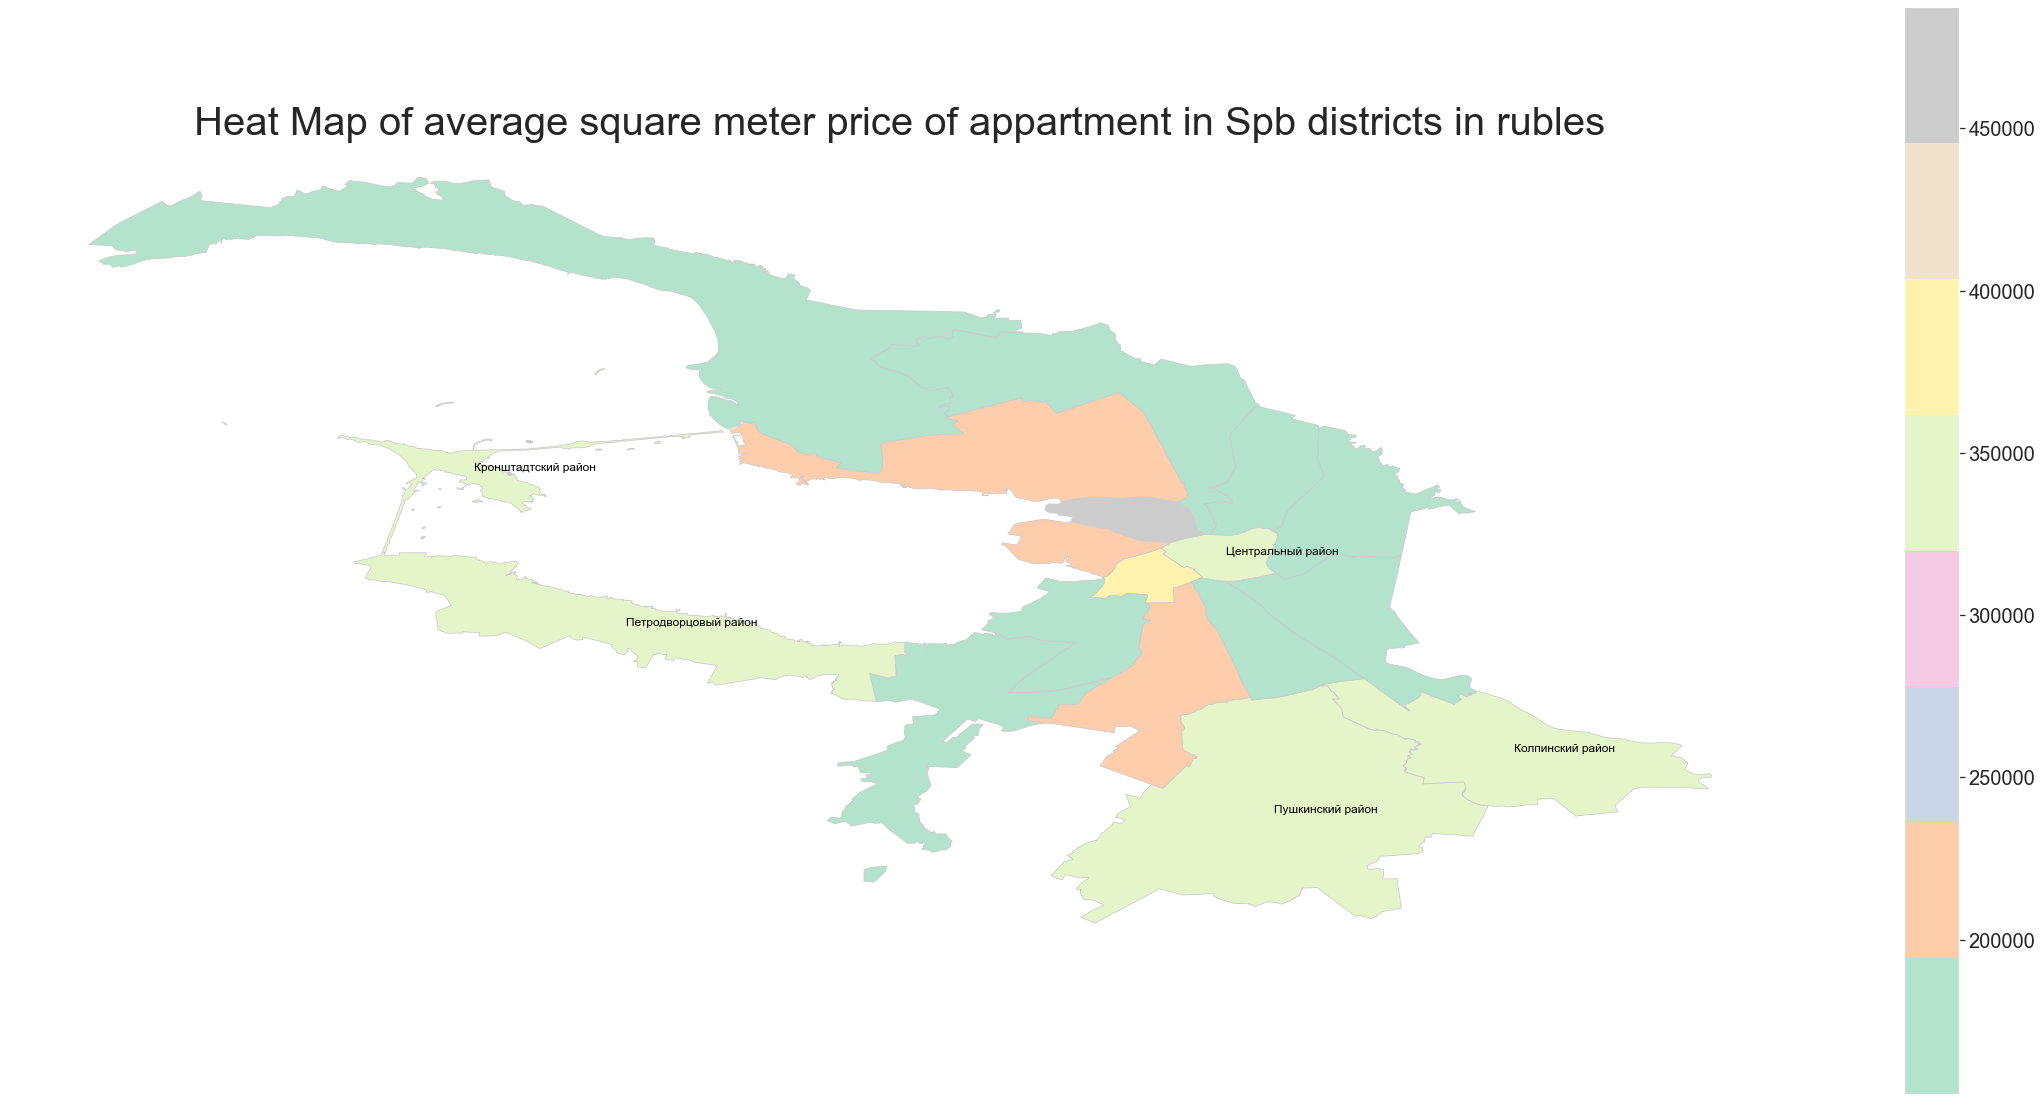

In [113]:
heat_city("ekaterinburg")

heat_city("spb")

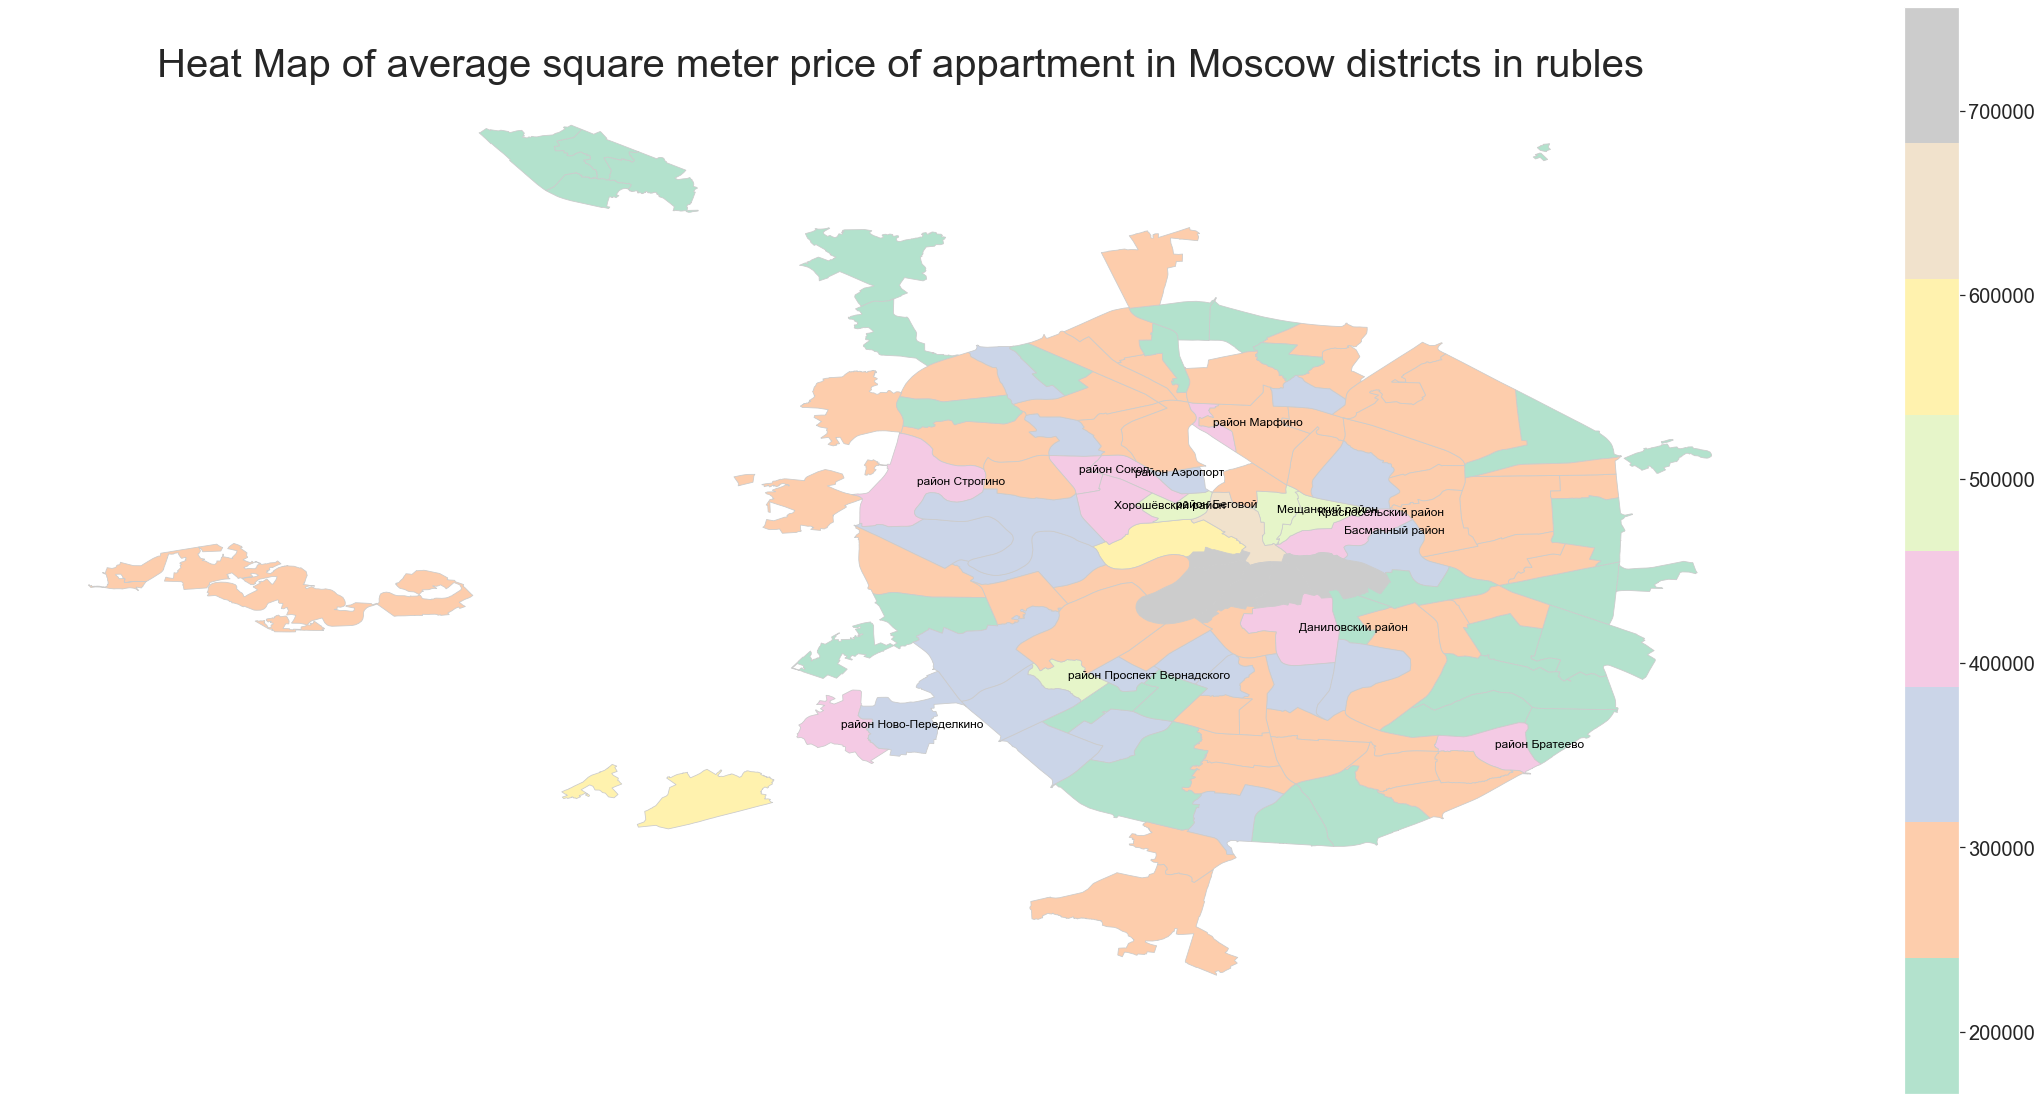

In [112]:
heat_city("moscow")